# 0. Load  data and transform

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from scripts.load_data import load_data
from scripts.plot_collection_lag_distribution import plot_collection_lag_distribution
folder_path = '/Users/CUDAN/Documents/GitHub/data_analysis_portfolio/data' #uni macbook
museums_data, museum_names = load_data(folder_path, filter_data=True)

/Users/CUDAN/Documents/GitHub/data_analysis_portfolio/scripts/load_data.py:18: DtypeWarning: Columns (5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame


In [2]:
collection_lag = []
for df in museums_data:
    # Calculate collection lag
    df['Collection_lag'] = pd.NA
    df['Year_acquisition'] = pd.to_numeric(df['Year_acquisition'], errors='coerce')
    df['Date_creation_year'] = pd.to_numeric(df['Date_creation_year'], errors='coerce')
    df['Collection_lag'] = df['Year_acquisition'] - df['Date_creation_year']
    
    # Group and count, specifying which column to count
    new_df = (df.groupby('Collection_lag')
              .size()  # Count occurrences
              .reset_index(name='count'))  # Reset index and name the count column
    
    collection_lag.append(new_df)

# 1. Plot collection lag distributions

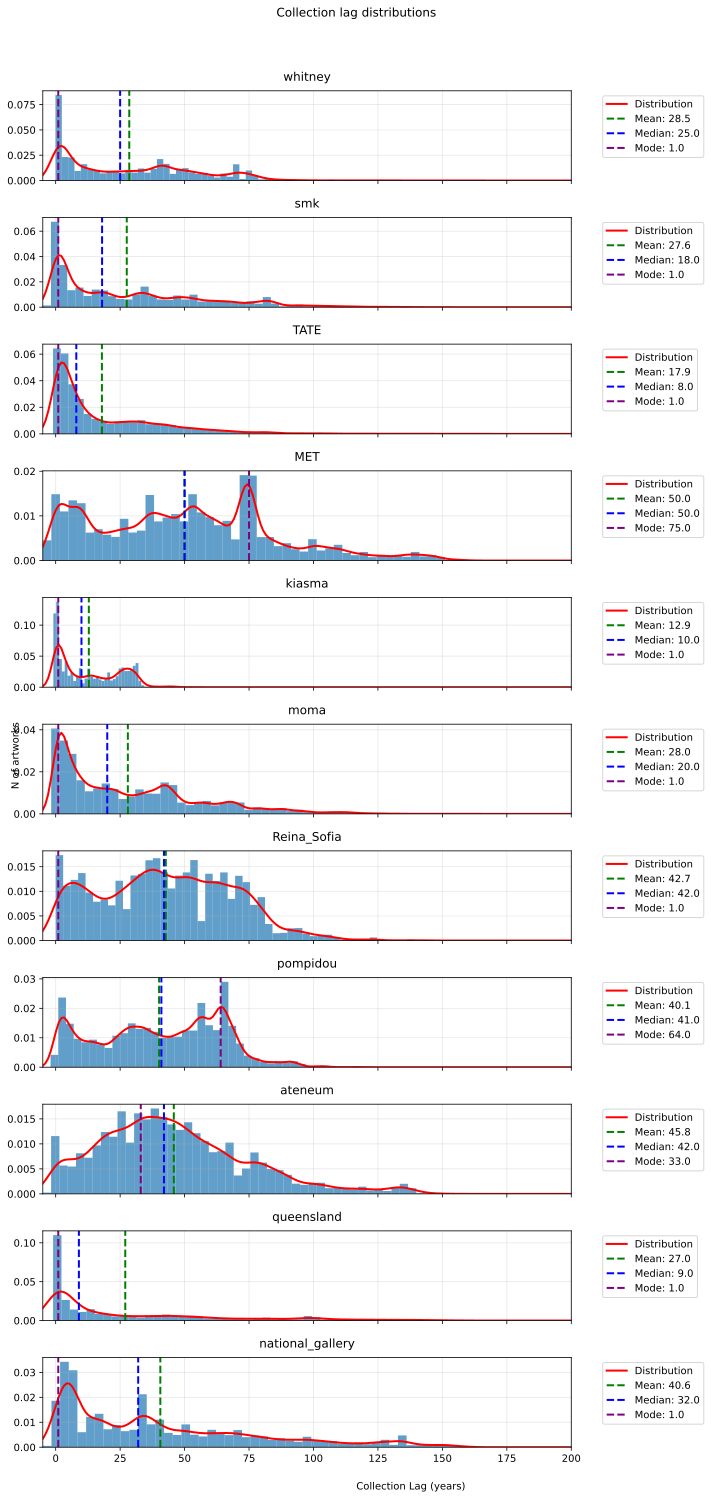

In [3]:
plot_collection_lag_distribution(collection_lag, museum_names)

In [13]:
import pandas as pd
import numpy as np

def calculate_Age_artist_acquisition(df):
    """
    Calculate the age of artists at the time of artwork acquisition.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing Year_acquisition and Artist_birth_year columns
    
    Returns:
    pandas.DataFrame: DataFrame with new/updated Age_artist column
    """
    
    # Convert relevant columns to numeric, with invalid values becoming NaN
    year_acq = pd.to_numeric(df['Year_acquisition'], errors='coerce')
    birth_year = pd.to_numeric(df['Artist_birth_year'], errors='coerce')
    
    # Calculate age for all rows at once
    df['Age_artist'] = year_acq - birth_year
    
    # Set age to NA where conditions are not met:
    # 1. Year_acquisition <= 0
    # 2. Artist_birth_year <= 0
    # 3. Year_acquisition < Artist_birth_year
    # 4. Any NaN values in the calculation
    invalid_mask = (
        (year_acq <= 0) |
        (birth_year <= 0) |
        (year_acq < birth_year) |
        df['Age_artist'].isna()
    )
    
    df.loc[invalid_mask, 'Age_artist'] = pd.NA
    
    return df

In [16]:
import pandas as pd
import numpy as np

def calculate_artist_dead(df):
    """
    Calculate whether artists were dead at the time of artwork acquisition.
    Returns: DataFrame with new column 'Artist_was_dead'
    Values: 0 (alive), 1 (dead), -1 (died same year), NA (unknown)
    """
    
    # Initialize column with NA
    df['Artist_was_dead'] = pd.NA
    
    # Convert relevant columns to numeric, errors as NA
    year_acq = pd.to_numeric(df['Year_acquisition'], errors='coerce')
    death_year = pd.to_numeric(df['Artist_death_year'], errors='coerce')
    birth_year = pd.to_numeric(df['Artist_birth_year'], errors='coerce')
    age = pd.to_numeric(df['Age_artist'], errors='coerce')
    
    # Create masks for different conditions
    alive_mask = (year_acq < death_year) & year_acq.notna() & death_year.notna()
    dead_mask = (year_acq > death_year) & year_acq.notna() & death_year.notna()
    same_year_mask = (year_acq == death_year) & year_acq.notna() & death_year.notna()
    
    # Handle cases where death year is unknown
    unknown_death_mask = (death_year <= 0) | death_year.isna()
    super_old_mask = unknown_death_mask & (age > 100)
    possibly_alive_mask = unknown_death_mask & (age <= 100) & age.notna()
    
    # Apply all conditions at once
    df.loc[alive_mask, 'Artist_was_dead'] = 0
    df.loc[dead_mask, 'Artist_was_dead'] = 1
    df.loc[same_year_mask, 'Artist_was_dead'] = -1
    df.loc[super_old_mask, 'Artist_was_dead'] = 1
    df.loc[possibly_alive_mask, 'Artist_was_dead'] = 0
    
    return df

In [ ]:
#collection lag for alive artists

collection_lag_alive = []
collection_lag_dead = []
for df in museums_data:
    calculate_Age_artist_acquisition(df)
    calculate_artist_dead(df)
    # Calculate collection lag
    df['Collection_lag'] = pd.NA
    df['Year_acquisition'] = pd.to_numeric(df['Year_acquisition'], errors='coerce')
    df['Date_creation_year'] = pd.to_numeric(df['Date_creation_year'], errors='coerce')
    df['Collection_lag'] = df['Year_acquisition'] - df['Date_creation_year']
    # Group and count, specifying which column to count
    df_alive = (df.groupby(['Collection_lag', 'Artist_was_dead'])
              .size()  # Count occurrences
              .reset_index(name='count'))  # Reset index and name the count column
    
    collection_lag_alive.append(df_alive)

In [ ]:
def analyze_artist_status_distribution(df):
    """
    Create various pivot tables and analyses based on Artist_was_dead column.
    
    Values in Artist_was_dead:
    0: Artist was alive
    1: Artist was dead
    -1: Artist died same year
    NA: Unknown
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing Artist_was_dead column
    
    Returns:
    dict: Different pivot tables and analyses
    """
    results = {}
    
    # 1. Basic count of artworks by artist status
    status_mapping = {
        0: 'Alive',
        1: 'Dead',
        -1: 'Died Same Year',
        pd.NA: 'Unknown'
    }
    
    df['Artist_Status'] = df['Artist_was_dead'].map(status_mapping)
    
    return results

In [25]:
test = collection_lag_alive[0]